# Data upload

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import Preprocessing as pproc 
import HerdingFunctions as hf

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [2]:
# Extraction of the .tar files
pproc.extract_tar_files(data_path)

In [5]:
#Transformation of the .txt files
pproc.text_to_csv(RB_path, 'ratings')
pproc.text_to_csv(RB_path, 'reviews')

pproc.text_to_csv(BA_path, 'ratings')
pproc.text_to_csv(BA_path, 'reviews')

pproc.text_to_csv(MB_path, 'ratings_ba')
pproc.text_to_csv(MB_path, 'ratings_with_text_ba')
pproc.text_to_csv(MB_path, 'ratings_rb')
pproc.text_to_csv(MB_path, 'ratings_with_text_rb')

# Creation of dataframes

Matching data:

In [2]:
MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)

In [3]:
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

Rest of the data:

In [4]:
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')

In [5]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')

In [18]:
BA_ratings

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quick...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393027,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1141038000,jaluria,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80,I'll start off reviewing this beer with the f...,True
8393028,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1140346800,Dithyramb,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80,Served on draft at the pub. Poured a clear ye...,True
8393029,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1092132000,ManekiNeko,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54,Served on tap at the brewpub in a pint glass....,True
8393030,Nut Brown Ale,19140,Summit Station Restaurant & Brewery,885,English Brown Ale,5.3,1341741600,Redsox1539,redsox1539.683632,NaN,NaN,NaN,NaN,NaN,3.50,NaN,False


# Popularity analysis over time

The rationale behind this idea is to be able to match or provide fun facts to the users of our social network about which would have been the perfect year for them to live in according to their preferences.

Doing a time analysis of beer popularity over time, we will be using the matched dataset since we are not considering a comparison between BeerAdvocate and RateBeer but uncovering trends in beers over the years. According to the article by G. Lederrey and R. West (https://doi.org/10.1145/3178876.3186160), the matched set has gone through internal and external validity in terms of being unbiased with respect to countries and beer style distributions and rating being "approximately independent of site and product properties".

However, in order to analyze the top ranked beers for each year, we would need to consider the herding effect. In other words, if for a certain year there is a larger number of ratings coming from the database that has being positively impacted by the herding effect, the average in rating will be higher than in the opposite case. Also, the herding effect although continuing to be present, has a lower effect when the number of ratings for the beer is higher. It becomes approximately a stable value after the 5th rating.

Thus, we will start by analyzing the distribution of the number of ratings for each bear to discard the beers with a very low number of ratings. Then, dividing the beers into 3 groups (small = S, medium = M and large = L) according to the number of ratings, we will perform the relative ratios from the average between the previous reviews in each webpage and the review n, to quantify the hearding effect and perform detrending before computing the macro-average to determine the top 3 ranked beers per year.

In [10]:
# Filtering of the data to only keep the useful columns
columns_to_keep = ['beer_id', 'beer_name','beer_id.1','beer_name.1','nbr_ratings', 'nbr_ratings.1', 'style', 'style.1','diff','sim']

# Keep the specified columns
MB_beers_filtered = MB_beers.filter(columns_to_keep)
MB_beers_filtered = MB_beers_filtered.rename(columns={'beer_id': 'beer_id_BA', 'beer_name': 'beer_name_BA', 'beer_id.1': 'beer_id_RB', 'beer_name.1': 'beer_name_RB', 'nbr_ratings': 'nbr_ratings_BA', 'nbr_ratings.1': 'nbr_ratings_RB', 'style': 'style_BA', 'style.1': 'style_RB'})
MB_beers_filtered

,beer_id_BA,beer_name_BA,beer_id_RB,beer_name_RB,nbr_ratings_BA,nbr_ratings_RB,style_BA,style_RB,diff,sim
0,19827,Legbiter,37923,Strangford Lough Legbiter,75,89,English Pale Ale,Golden Ale/Blond Ale,1.000000,1.0
1,20841,St. Patrick's Ale,41286,Strangford Lough St. Patricks Ale,8,11,English Pale Ale,Irish Ale,0.527141,1.0
2,20842,St. Patrick's Best,41287,Strangford Lough St. Patricks Best,64,74,English Bitter,Bitter,0.527141,1.0
3,22659,St. Patrick's Gold,41285,Strangford Lough St. Patricks Gold,1,4,American Pale Wheat Ale,Amber Ale,0.527141,1.0
4,178681,Sheelin Stout,230283,Sheelin Stout,0,2,Irish Dry Stout,Mild Ale,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
45635,96911,Pale Ale,242782,Do Can Pale Ale,4,1,English Pale Ale,India Pale Ale (IPA),1.000000,1.0
45636,37457,Mustang Gold Ale,68764,Warbird Mustang Gold Ale,22,57,American Blonde Ale,Golden Ale/Blond Ale,0.806680,1.0
45637,47287,Shanty Irish,76984,Warbird Shanty Irish,10,50,Irish Red Ale,Irish Ale,1.000000,1.0
45638,37177,Thunderbolt Wheat,78298,Warbird Thunderbolt Wheat,21,59,Hefeweizen,German Hefeweizen,1.000000,1.0


Text(0.5, 0, 'Number of ratings (RB)')

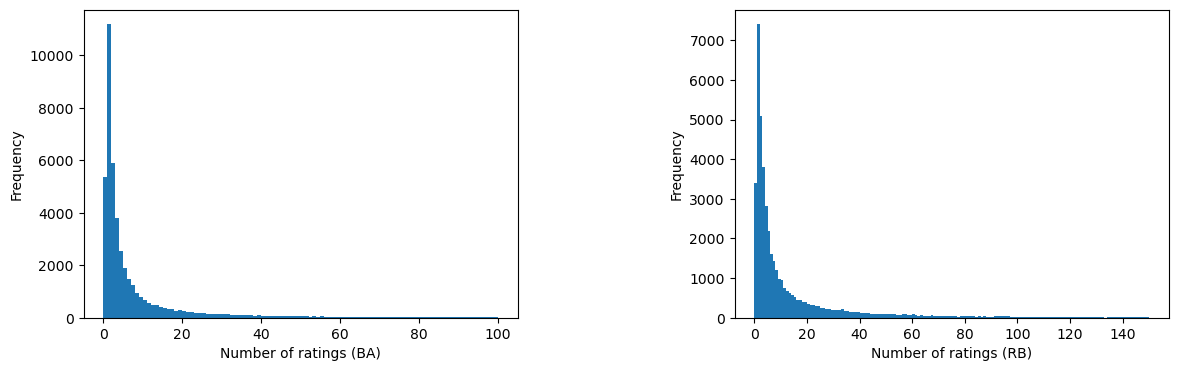

In [11]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

MB_beers_filtered['nbr_ratings_BA'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0])
axs[0].set_xlabel('Number of ratings (BA)')
MB_beers_filtered['nbr_ratings_RB'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1])
axs[1].set_xlabel('Number of ratings (RB)')

In [12]:
MB_beers_filtered.nbr_ratings_BA.describe()

count    45640.000000
mean        20.945837
std        137.768038
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       9228.000000
Name: nbr_ratings_BA, dtype: float64

In [13]:
MB_beers_filtered.nbr_ratings_RB.describe()

count    45640.000000
mean        22.362796
std         80.107455
min          0.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       5272.000000
Name: nbr_ratings_RB, dtype: float64

Seeing this basic statistics and having observed the histograms we will filter out so that we keep beers with at least 5 ratings for both of the datasets (columns 'nbr_ratings_BA' and 'nbr_ratings_RB'). This will later help us in dimishing the **herding effect**.

In [14]:
filt_MB_beers = MB_beers_filtered[(MB_beers_filtered['nbr_ratings_BA'] >= 5) & (MB_beers_filtered['nbr_ratings_RB'] >= 5)].copy(deep=True) 

Fig. 6 in the previously mentioned paper, shows that the herding effect, although never converging to 0, becomes stable with a larger number of ratings with respect to the first one. Thus, we will keep the beers with at least 5 ratings. Note that 5 is the median value of the number of ratings in RateBeer but, in the case of BearAdvocate, it is below it. However, discarding these samples still leaves us with approximately 30% of the data which is a large amount of data (12890 beers).
Then, we will devide the data into 3 groups, trying to make groups with a similar amount of data (although not exactly equal) in terms of the number of received ratings by using the tertiales of the filtered dataframe.

In [15]:
display(filt_MB_beers['nbr_ratings_BA'].quantile([0.33, 0.67]))
filt_MB_beers['nbr_ratings_RB'].quantile([0.33, 0.67])

0.33    11.0
0.67    31.0
Name: nbr_ratings_BA, dtype: float64

0.33    11.0
0.67    36.0
Name: nbr_ratings_RB, dtype: float64

Now, we will do a scatter plot for each beer (in different colors) to see the trend in the herding effect. We will quantize the effect as the relation with respect to the average of the previous ratings. Note that this graph will be measured up until the minimum number of ratings used to determine the partition in the previous step (since this is the assured number of ratings that all the beers in the group will have).

Since we are planning to do a time analysis throughout the different years, we will transform the date column to an interpretable data type. This will also be used to calculate the z-score for each of the ratings.

### Time-analysis required preprocessing of the data

In [72]:
MB_ratingsBA['date'] = pd.to_datetime(MB_ratingsBA.date, unit='s')
MB_ratingsBA['year'] = MB_ratingsBA['date'].dt.year

MB_ratingsRB['date'] = pd.to_datetime(MB_ratingsRB.date, unit='s')
MB_ratingsRB['year'] = MB_ratingsRB['date'].dt.year

BA_ratings['date'] = pd.to_datetime(BA_ratings.date, unit='s')
BA_ratings['year'] = BA_ratings['date'].dt.year

RB_ratings['date'] = pd.to_datetime(RB_ratings.date, unit='s')
RB_ratings['year'] = RB_ratings['date'].dt.year

In [73]:
# Calculation of the z-score for each beer (not for the mean score of the beer that is what we have in BA_beers or RB_beers)
BA_ratings['z_score'] = BA_ratings.groupby('year')['rating'].transform(lambda x: (x-x.mean())/x.std())
RB_ratings['z_score'] = RB_ratings.groupby('year')['rating'].transform(lambda x: (x-x.mean())/x.std())

In [74]:
# We will add the z-score value to the corresponding MB_rating
MB_ratingsBA = MB_ratingsBA.merge(BA_ratings, how='inner').copy(deep=True)
MB_ratingsRB = MB_ratingsRB.merge(RB_ratings, how='inner').copy(deep=True)

### BA data

In [75]:
# BA data
S_beer_id_BA = filt_MB_beers.beer_id_BA[filt_MB_beers['nbr_ratings_BA']<=11].to_numpy()
M_beer_id_BA = filt_MB_beers.beer_id_BA[(filt_MB_beers['nbr_ratings_BA']>11) & (filt_MB_beers['nbr_ratings_BA']<=31)].to_numpy()
L_beer_id_BA = filt_MB_beers.beer_id_BA[filt_MB_beers['nbr_ratings_BA']>31].to_numpy()

In [76]:
S_ratings_BA = MB_ratingsBA[MB_ratingsBA['beer_id'].isin(S_beer_id_BA)].copy(deep=True)
M_beer_id_BA = MB_ratingsBA[MB_ratingsBA['beer_id'].isin(M_beer_id_BA)].copy(deep=True)
L_beer_id_BA = MB_ratingsBA[MB_ratingsBA['beer_id'].isin(L_beer_id_BA)].copy(deep=True)

In [77]:
# Expanding mean as a function of ith rating z-score
S_ratings_BA = S_ratings_BA.sort_values(by=['beer_id', 'date']) #Sort according to the beer_id and, after that, according to date
S_ratings_BA['exp_mean'] = S_ratings_BA.groupby('beer_id')['z_score'].transform(lambda x: x.expanding().mean())

In [96]:
# Create new column with difference between the expanded mean and the minimum rating used to subdivide the data
S_ratings_BA['diff_exp_mean'] = S_ratings_BA.groupby('beer_id')['exp_mean'].transform(lambda x: x.iloc[4] - x)
S_ratings_BA['diff_exp_mean'] = S_ratings_BA.groupby('beer_id')['diff_exp_mean'].transform(lambda x: np.where(np.arange(len(x)) == 4, np.nan, x))

Text(0, 0.5, 'Diff 5th rating and ith rating expanding average')

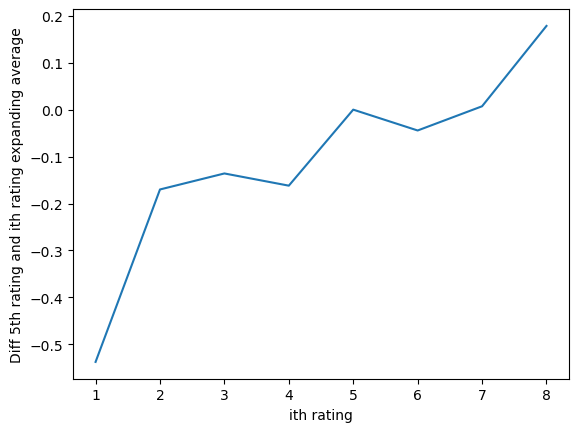

In [116]:
# Plot with just the first beer for a better comprehension

# Group by 'Beer ID' for this example
grouped_S_BA = S_ratings_BA.groupby('beer_id')['diff_exp_mean']

first_group_ID = list(grouped_S_BA.groups.keys())[0]
first_group = grouped_S_BA.get_group(first_group_ID)

plt.plot(np.arange(len(first_group))+1, first_group.fillna(0))
plt.xlabel('ith rating')
plt.ylabel('Diff 5th rating and ith rating expanding average')

In [ ]:
# Detrending


In [ ]:
# Once we have found the trend --> calculate the deviation from the mean and subtract it to detrend. CHECK WHAT PARAMETER WILL WE 
# USE TO DETREND

### RB data

In [34]:
# RB data
S_beer_id_RB = filt_MB_beers.beer_id_RB[filt_MB_beers['nbr_ratings_RB']<=11].to_numpy()
M_beer_id_RB = filt_MB_beers.beer_id_RB[(filt_MB_beers['nbr_ratings_RB']>11) & (filt_MB_beers['nbr_ratings_BA']<=36)].to_numpy()
L_beer_id_RB = filt_MB_beers.beer_id_RB[filt_MB_beers['nbr_ratings_RB']>36].to_numpy()

In [ ]:
S_ratings_RB = MB_ratingsRB[MB_ratingsRB['beer_id'].isin(S_beer_id_RB)]
M_beer_id_RB = MB_ratingsRB[MB_ratingsRB['beer_id'].isin(M_beer_id_RB)]
L_beer_id_RB = MB_ratingsRB[MB_ratingsRB['beer_id'].isin(L_beer_id_RB)]